In [3]:
import numpy as np 
import torch 
import ot 
import os
parent_path=%pwd 

os.chdir(parent_path)
from lib.gromov_test import partial_gromov_v1,partial_gromov_v2, cost_matrix_d,tensor_dot_param,tensor_dot_func,gwgrad_partial,partial_gromov_wasserstein
import lib.gromov_test as test
import lib.gromov as gw
from lib.opt import *


import numpy as np 
import numba as nb
import warnings
import time
from ot.backend import get_backend, NumpyBackend
from ot.lp import emd
#import unbalanced GW 

from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn,log_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost
from lib.unbalanced_gromov_wasserstein.unbalancedgw.utils import generate_measure

In [4]:
#@nb.njit(fastmath=True)
def generate_d_square(d,n):
    x_list=[]
    for i in range(d):
        x = np.linspace(-1, 1, n)
        x_list.append(x)
    xx= np.meshgrid(*x_list,indexing='ij')
    data=np.zeros((n**d,d))
    for i in range(d):
        data[:,i]=xx[i].reshape(-1)
    return data


#@nb.njit(fastmath=True)
def generate_d_sphere(d,n,seed=20):
    np.random.seed(seed)
    N=n**d
    data=np.random.normal(size=(N,d))
    norm=np.sqrt(np.sum(np.square(data),1)).reshape(-1,1)
    data=data/norm
    return data

In [6]:
k=3
n2=k**3
n3=k**2

np.random.seed(4)
sq2=generate_d_square(d=2,n=n2)
sq3=generate_d_square(d=3,n=n3)+np.array([0,0,3])
sp2=generate_d_sphere(d=2,n=n2)+np.array([7,0])
sp3=generate_d_sphere(d=3,n=n3)+np.array([7,0,0])+np.array([0,0,3])

p_sq2=np.ones(sq2.shape[0])/sq2.shape[0]
p_sq3=np.ones(sq3.shape[0])/sq3.shape[0]
p_sp2=np.ones(sp2.shape[0])/sp2.shape[0]
p_sp3=np.ones(sp3.shape[0])/sp3.shape[0]

X=np.concatenate((sq2,sp2))
Y=np.concatenate((sq3,sp3))
p=np.concatenate((0.3*p_sq2,0.7*p_sp2))
q=np.concatenate((0.5*p_sq3,0.5*p_sq3))

C1=cost_matrix_d(X,X)
C2=cost_matrix_d(Y,Y)
n=X.shape[0]
print(X.shape[0])
print(Y.shape[0])

1458
1458


In [7]:
# without prior knowledge 

time1=time.time()
gamma1=ot.gromov.gromov_wasserstein(C1,C2,p,q)
n=X.shape[0]
time2=time.time()
print('time of gromov_wasserstein is', time2-time1)


# time1=time.time()
# gamma2,log1=gw.partial_gromov_v1(C1,C2,p,q,Lambda=400.0,numItermax=100*n,thres=1,tol=1e-5,log=False)
# time2=time.time()

# print('time of v1 is', time2-time1)
# print('gamma 2 mass',gamma2.sum())

time1=time.time()
gamma2,log1=gw.partial_gromov_v1(C1,C2,p,q,Lambda=400.0,numItermax=100*n,thres=1,tol=1e-5,log=False)
time2=time.time()
print('mass of G2',gamma2.sum())
print('time of v1 is', time2-time1)



mass=0.8
G0=np.outer(p,q)/(np.sum(p)*np.sum(q))*mass
print('G0 mass is',G0.sum())
time1=time.time()
gamma2_1=partial_gromov_wasserstein(C1,C2,p,q, G0=G0,m=0.8,numItermax=100*n,thres=1,tol=1e-5,log=False)
time2=time.time()
print('time of primal is', time2-time1)

C1_T=torch.from_numpy(C1).to(torch.float32)
C2_T=torch.from_numpy(C1).to(torch.float32)
p_T=torch.from_numpy(p).to(torch.float32)
q_T=torch.from_numpy(q).to(torch.float32)
time1=time.time()
gamma3T,_=log_ugw_sinkhorn(a=p_T, dx=C1_T, b=q_T, dy=C2_T, init=None, eps=eps,
                             rho=8.0, rho2=None,
                             nits_plan=1000, tol_plan=1e-5,
                             nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                             two_outputs=True)
time2=time.time()
gamma3=gamma3T.numpy()
print('time of ugw is', time2-time1)

KeyboardInterrupt: 

Gamma1


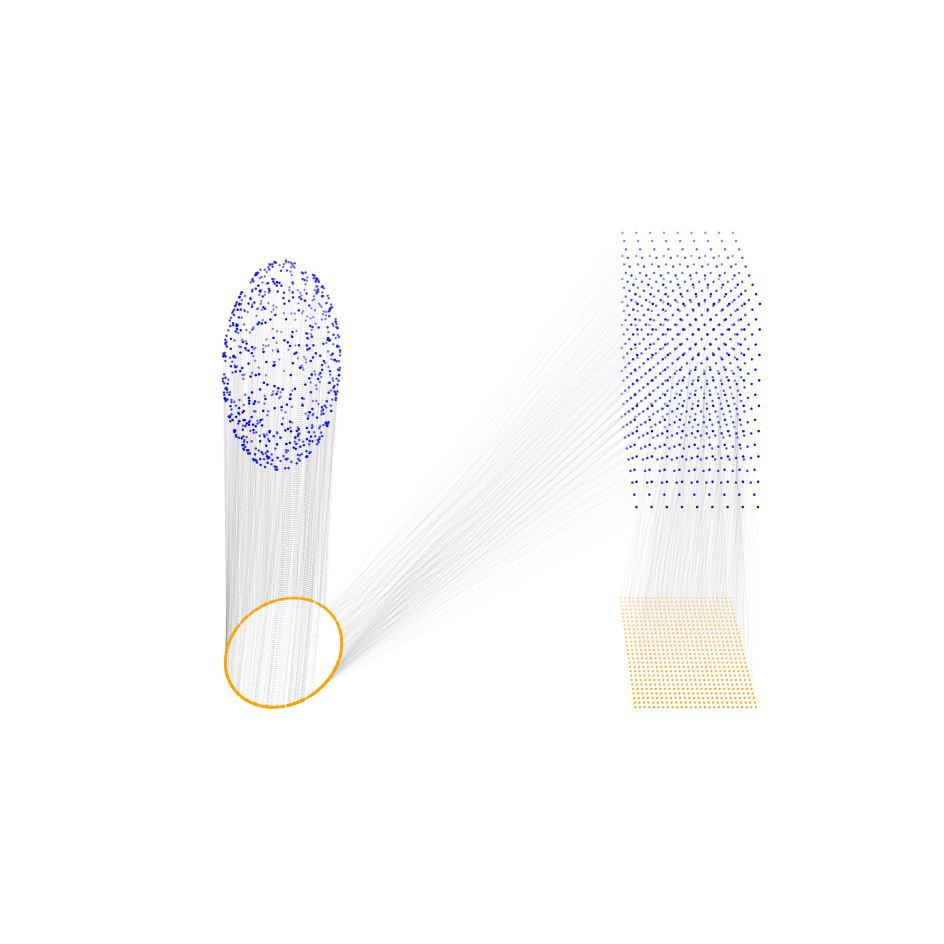

Gamma2


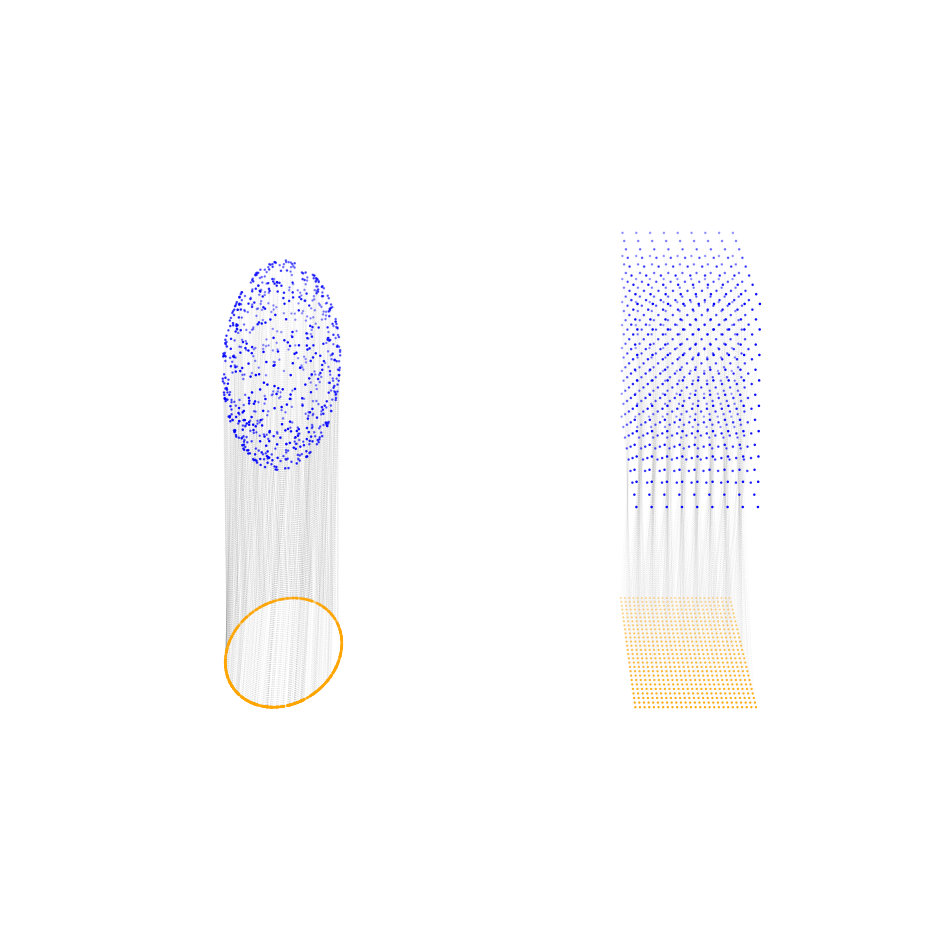

Gamma21


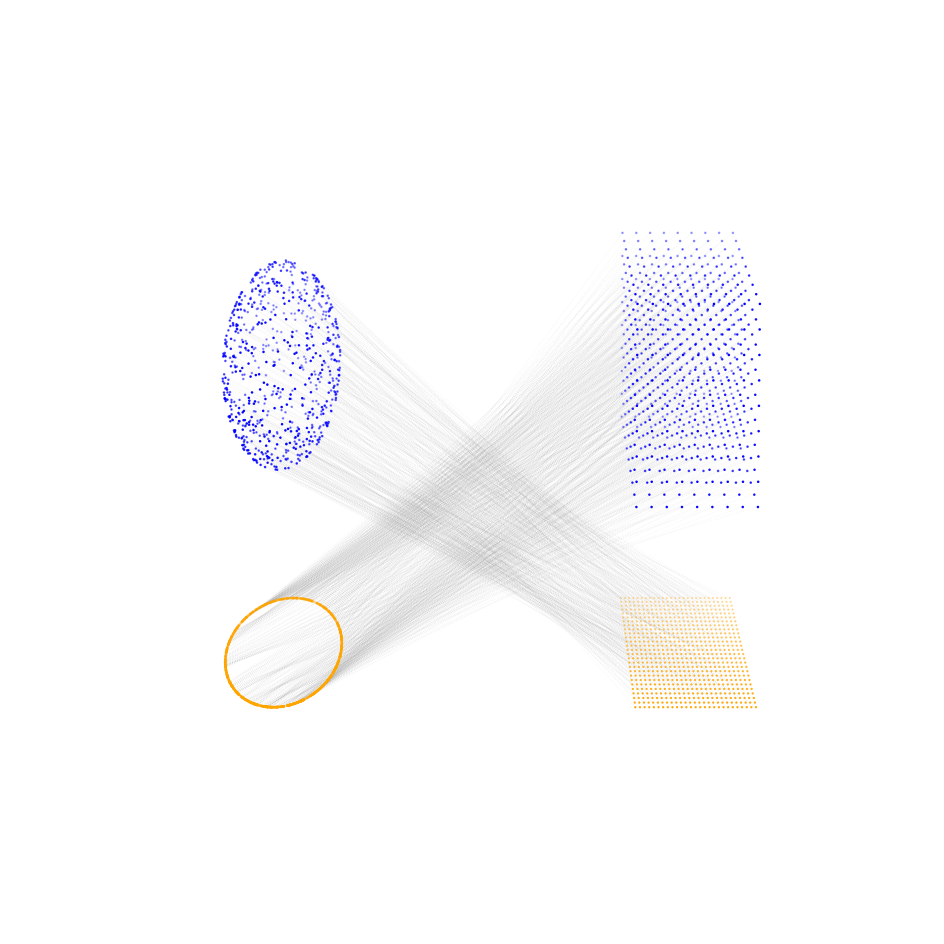

Gamma3


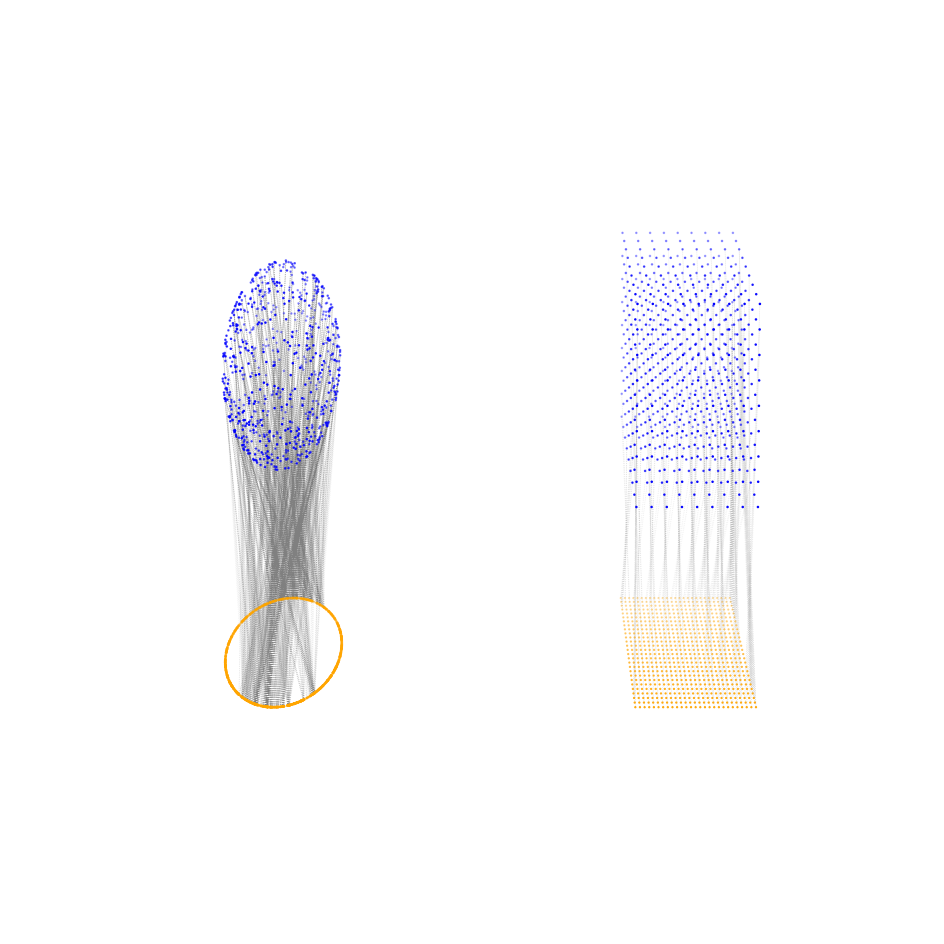

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def embed_3d(X):
    N,d=X.shape
    if d<3:
        X1=np.zeros((N,3))
        X1[:,0:d]=X
    else:
        X1=X.copy()
    return X1




def visual_plot(X,Y,p,q,gamma,eps=0.0004,save_name=None):
    X=embed_3d(X)
    Y=embed_3d(Y)
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    # Adding legend
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')
    ax.set_facecolor('white') 
    
    # Plotting the scatter plot for shape X in orange
    scatter_X = ax.scatter(X[:,0], X[:,1], X[:,2], s=1000*p, color='orange', label='Shape X')

    # Plotting the scatter plot for shape Y in blue
    scatter_Y = ax.scatter(Y[:,0], Y[:,1], Y[:,2], s=1000*q,color='blue', label='Shape Y')
    
    # show gamma:
    for (idx,x_point) in enumerate(X):
        for (idy,y_point) in enumerate(Y):
            if gamma[idx,idy]>eps:
                ax.plot([x_point[0], y_point[0]], [x_point[1], y_point[1]], [x_point[2], y_point[2]], linestyle=':', linewidth=0.5, alpha=0.1, color='grey')


        
    ax.view_init(10,90,0)
    if save_name is not None:
        plt.savefig('result/shape_matching/'+save_name+'.png',dpi=200,bbox_inches='tight', pad_inches=0)
    # Show plot
    plt.show()

print('Gamma1')
visual_plot(X,Y,p,q,gamma1,save_name='gw_3',eps=4e-4)
print('Gamma2')
visual_plot(X,Y,p,q,gamma2,save_name='pgw_3',eps=4e-4)

print('Gamma21')
visual_plot(X,Y,p,q,gamma2_1,save_name='pr_pgw_3',eps=4e-4)


gamma3=gamma3T.numpy().astype(np.float64)
print('Gamma3')
visual_plot(X,Y,p,q,gamma3,save_name='ugw_3',eps=2.1*1e-5)

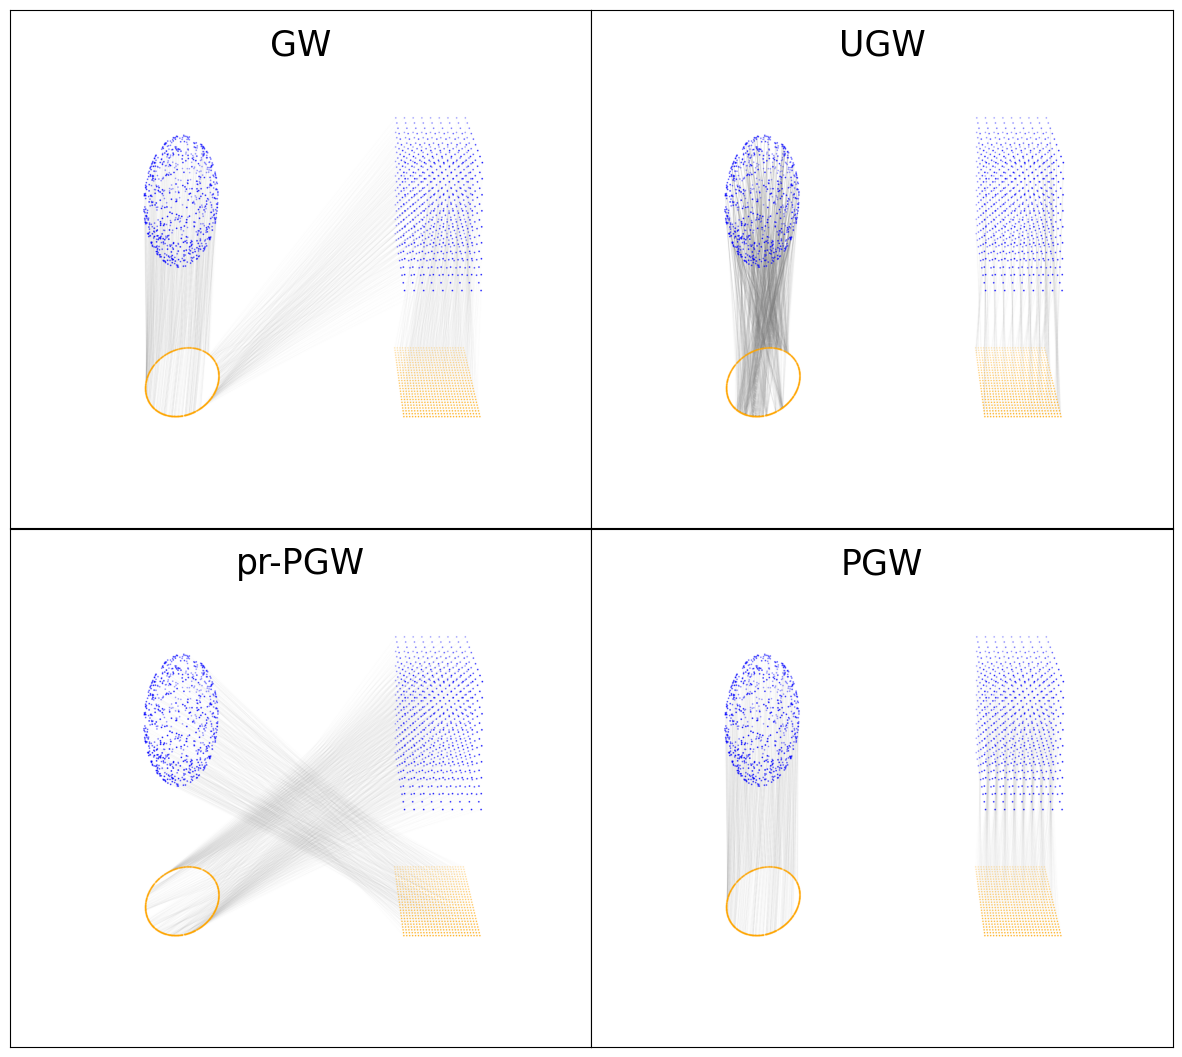

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
rows=2
cols=2
fig, axs = plt.subplots(rows, cols, figsize=(3*5, 12*5))
# Remove the gaps between subplots

save_path='result/shape_matching/'
figure_list=['gw_3','ugw_3','pr_pgw_3','pgw_3']
for (i,(method,figure)) in enumerate(zip(['GW','UGW','pr-PGW','PGW'],figure_list)):
    i1,i2=np.divmod(i,2)
    #print('i1',i1)
    #print('i2',i2)
    path=save_path+figure+'.png'
    img = mpimg.imread(path)
    img_crop=img[100:-100,:,:]
    axs[i1,i2].imshow(img_crop)
    axs[i1,i2].set_xticks([])
    axs[i1,i2].set_yticks([])
#    axs[i1,i2].set_xlabel(method,fontsize=15)
    axs[i1,i2].set_title(method,fontsize=25,y=0.95, pad=-14)

plt.subplots_adjust(wspace=0, hspace=-0.8735)

#plt.subplots_adjust(wspace=0, hspace=-0.5)
plt.savefig('result/shape_matching/shape_wo.png',dpi=200, bbox_inches='tight', pad_inches=0)
plt.savefig('result/shape_matching/shape_wo.pdf',dpi=200, bbox_inches='tight', pad_inches=0)
# Display the figure
plt.show()